In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as timeit

In [2]:
def K(p):
    return p.T.dot(p)/2

def dK(p):
    return p

def U(q):
    q1 = q[0]
    q2 = q[1]
    return .5*(q1**2 + q2**2) + q2*q1**2 - (1/3.)*q2**3

def dU(q):
    q1 = q[0]
    q2 = q[1]
    x1 = q1 + 2*q1*q2
    x2 = q1**2 + q2 - q2**2
    return np.array([[x1],[x2]]).reshape(2,1)

def H(p,q):
    return K(p) + U(q)

#t = np.array([[2],[3]])
#T(t)
#U(t)
#dU(t)
#H(t,t)

In [3]:
Dim = 2
M = np.identity(Dim)
Minv = np.linalg.inv(M)
p0 = np.array([[-.28],[.23]]).reshape(2,1)
q0 = np.array([[.23],[-.28]]).reshape(2,1)
H0 = np.squeeze(H(p0,q0))
print(f'Initial energy: {H0}')

Initial energy: 0.12380533333333335


### Monitor Functions ($G$)
In general for function $G$,
$$G(\mathbf{y}) = -\frac{1}{\sigma(\mathbf{y})}\nabla\sigma(\mathbf{y})^{\top}f(\mathbf{y}),$$
where $\mathbf{y}$ can be $\mathbf{y}=(\mathbf{p},\mathbf{q})$ or just $\mathbf{q}$ depending on the design of $\sigma$.

**Sa. ($\sigma_a$)**<br>
$\sigma_a(\mathbf{q}) =\left((H_0-U(\mathbf{q})) + \nabla U(\mathbf{q})^{\top}\mathbf{M}^{-1}\,\nabla U(\mathbf{q})\right)^{-\frac{1}{2}} $<br>
<br>
**Sb. ($\sigma_b$)**<br>
$\sigma_b (\mathbf{q}) = (H_0 - U(\mathbf{q}))^{-\frac{1}{2}}$ <br>
*Notes: This function had issues with negative values under the square root. Likely, this is related to the topology of the function depending on location in potential. The values of $\sigma_b$ explode after about 10 steps. Trajectories begin in the lower left corner and this explosion of values corresponded to hitting a wall of the potential (first compression of points for $\sigma_a$).*

**Sc. ($\sigma_c$)**<br>
$\sigma_c(\mathbf{q}) = \lvert|\mathbf{q}\rvert|^{\alpha}$, where $\alpha = 2$.

In [61]:
def Sa(q,h0):
    uq = U(q)
    duq = dU(q)
    return (1/np.sqrt((h0-uq) + np.dot(duq.T, np.dot(Minv,duq))))[0,0]
#Sa(q0,H0)

def dSa(q):
    q1 = q[0,0]
    q2 = q[1,0]
    qx = -q1 + 2*q1*q2 + 2*(1+2*q2)*(q1+2*q1*q2) + 4*q1*(q1**2+q2-q2**2)
    qy = q1**2 - q2 - q2**2 + 4*q1*(q1+2*q1*q2) +  2*(1-2*q2)*(q1**2+q2-q2**2)
    return np.array([[qx],[qy]])

def Sb(q,h0):
    return 1/np.sqrt(h0 - U(q))

def dSb(q,h0):
    return (.5*Sb(q,h0)**3)*dU(q)

def Sc(q):
    return 1/np.dot(q.T,q)[0,0]

def dSc(q):
    return (-1/Sc(q)**2)*q

In [62]:
def Ga(p,q,h0):
    return (-1/Sa(q,h0))*np.dot(dSa(q).T,p)

def Gb(p,q,h0):
    return (-1/Sb(q,h0))*np.dot(dSb(q,h0).T,p)

def Gc(p,q,h0):
    return (-1/Sc(q))*np.dot(dSc(q).T,p)

In [63]:
def sv(p, q, h, time):
    
    steps = int(time//h)
    position = np.zeros((2,steps))
    start = timeit()
    for i in range(steps):
        p -= (h/2.)*dU(q)
        q += h*p
        p -= (h/2.)*dU(q)
        position[:,i] = np.squeeze(q)
    print(f'sv runtime={timeit()-start}')
    return position

In [64]:
def VSV(G,p,q,h0,h,time):
    
    position = []
    energy = []
    cerr = []
    ssz = []
    totalSteps = 0.
    start = timeit()
    z = 1 - (h/2.)*G(p,q,h0)
    Z0 = z
    #Q0 = Q(q,h0)
    while(totalSteps < time):
        z = z + h*G(p,q,h0)
        p = p - .5*h*dU(q)/z
        q = q + h*dK(p)/z
        p = p - .5*h*dU(q)/z
        ssz.append(np.squeeze(h/z - h/Z0).tolist())
        totalSteps += h/z
        #cerr.append(np.abs(-Z0/Q0 + z/Q(q,h0)))
        energy.append(np.abs(np.squeeze(H(p,q)-h0)).tolist())
        position.append(np.squeeze(q).tolist())
    print(f'vsv runtime={timeit()-start}')
    return position, energy, ssz, cerr

In [65]:
h = 1e-1
Time = 13
#### Starting points
#p0 = np.array([[-.1],[.12]]).reshape(2,1)
#q0 = np.array([[.06],[-.09]]).reshape(2,1)

#p0 = np.array([[-.28],[.23]]).reshape(2,1)
#q0 = np.array([[.23],[-.28]]).reshape(2,1)

p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
print(f'Energy: {H(p0,q0)}')
Q2 = sv(p0,q0,h, Time)
#p = np.array([[-.3],[.31]]).reshape(2,1)
#q = np.array([[-.6],[-.5]]).reshape(2,1)


p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Qa, Es, Ss, _ = VSV(Ga,p0,q0,H0,h,Time)
Qa = np.array(Qa).T

#p0 = np.array([[-.3],[.31]]).reshape(2,1)
#q0 = np.array([[-.6],[-.5]]).reshape(2,1)
#Qb, Es, Ss, _ = VSV(Gb,p0,q0,H0,h,Time)
#Qb = np.array(Qb).T

p0 = np.array([[-.3],[.31]]).reshape(2,1)
q0 = np.array([[-.6],[-.5]]).reshape(2,1)
Qc, Es, Ss, _ = VSV(Gc,p0,q0,H0,h,Time)
Qc = np.array(Qc).T

Energy: [[0.25971667]]
sv runtime=0.005605936050415039
vsv runtime=0.011640787124633789
vsv runtime=0.013705968856811523


/tmp/ipykernel_3614325/1571203107.py:4: RuntimeWarning: invalid value encountered in sqrt
  return (1/np.sqrt((h0-uq) + np.dot(duq.T, np.dot(Minv,duq))))[0,0]


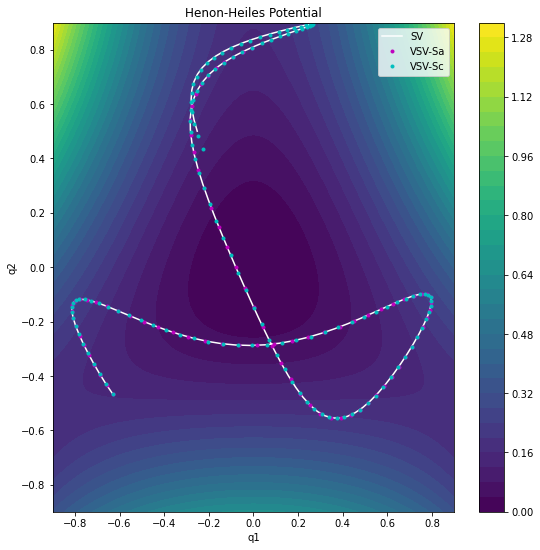

In [67]:
bnd = .9
xlist = np.linspace(-bnd, bnd, 1000)
ylist = np.linspace(-bnd, bnd, 1000)
X, Y = np.meshgrid(xlist, ylist)
Z = .5*(X**2 + Y**2) + Y*X**2 - (1/3.)*Y**3
fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=40)

ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qa[0,:],Qa[1,:],'m.', label='VSV-Sa')
#ax.plot(Qb[0,:],Qb[1,:],'r.', label='VSV-Sb')
ax.plot(Qc[0,:],Qc[1,:],'c.', label='VSV-Sc')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Henon-Heiles Potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

In [68]:
def Uc(qx,qy):
    return .5*(qx**2+qy**2) + qx**2*qy - (qy**3)/3

def dUc2(qx,qy):
    return (qx+2*qx*qy)**2 + (qx**2+qy-qy**2)**2

def Sac(X, Y, h0):
    return np.sqrt(h0 - Uc(X,Y) + dUc2(X,Y))

def Sbc(X,Y, h0):
    return np.sqrt(h0 - Uc(X,Y))

/tmp/ipykernel_3614325/1262439339.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(h0 - Uc(X,Y) + dUc2(X,Y))


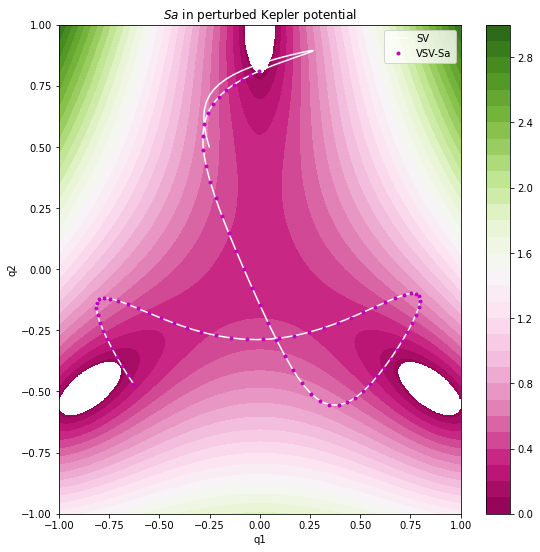

In [69]:
bnd = 1.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Sac(X,Y,H0)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=30, cmap ='PiYG')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qa[0,:],Qa[1,:],'m.', label='VSV-Sa')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sa$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

/tmp/ipykernel_3614325/1262439339.py:11: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(h0 - Uc(X,Y))


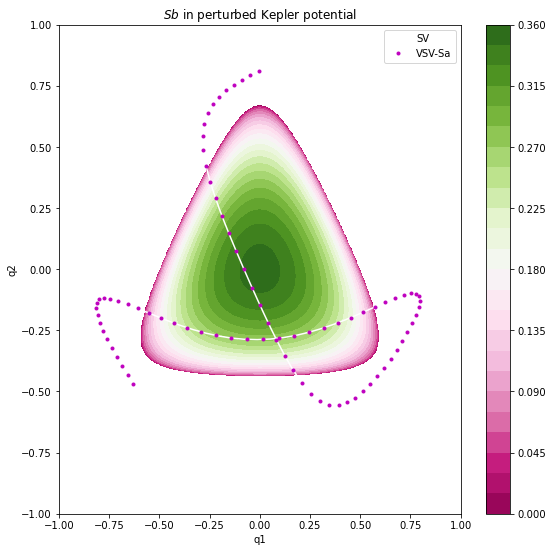

In [70]:
bnd = 1.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Sbc(X,Y,H0)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=30, cmap ='PiYG')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qa[0,:],Qa[1,:],'m.', label='VSV-Sa')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sb$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

In [79]:
def Scc(x,y):
    return 1/(X**2 + Y**2)

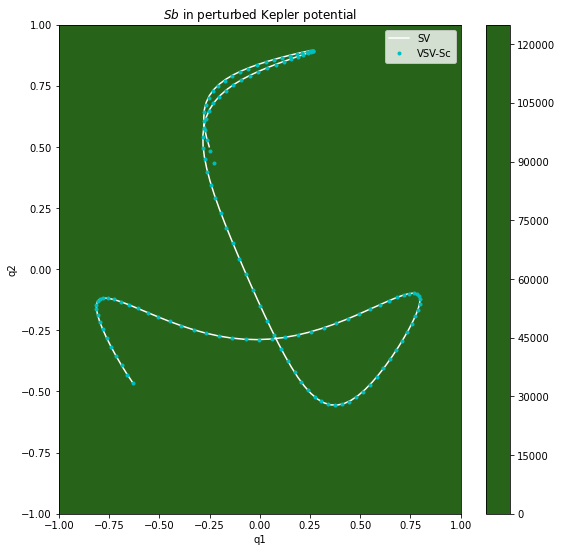

In [81]:
bnd = 1.
xlist = np.linspace(-bnd, bnd, 500)
ylist = np.linspace(-bnd, bnd, 500)
X, Y = np.meshgrid(xlist, ylist)
Z = Scc(X,Y)

fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, levels=30,
                 vmin=0., vmax=.5, cmap ='PiYG')
ax.plot(Q2[0,:],Q2[1,:],'white', label='SV')
ax.plot(Qc[0,:],Qc[1,:],'c.', label='VSV-Sc')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$Sb$ in perturbed Kepler potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()